### Exploring the data

In [1]:
import pandas as pd

df = pd.read_csv("C:/Users/jbandi/OneDrive - Seattle University/Documents/StatML_2/exploration_hospital_quarterly_financials_wa/data/raw/Hospital_Financial_Quarterly_Aggregate_Report_20250520.csv") 
df.head()

,License_Number,Hospital_Name,City,Year,Quarter,Licensed_Beds,Acute_Care_Medicare_Discharges,Acute_Care_Medicaid_Discharges,Acute_Care_Self_Pay_Discharges,Acute_Care_Commercial_Discharges,...,Net_Non_Operating_Gains_Losses,Tax_Subsidies,Gross_Total_Margin,Gross_Accounts_Receivable_Medicare,Gross_Accounts_Receivable_Medicaid,Gross_Accounts_Receivable_Self_Pay,Gross_Accounts_Receivable_Commercial,Gross_Accounts_Receivable_Other,Total_Gross_Accounts_Receivable,Casemix Index
0,42,Shriners Hospitals for Children - Spokane,Spokane,2019,1,30,0,25,0,0,...,0,0,0,466,2088844,0,0,2802386,4891696,2.1068
1,928,South Sound Behavioral Hospital,Lacey,2019,4,108,35,107,0,0,...,0,0,0,685949,1803523,0,0,722610,3212082,0.6334
2,42,Shriners Hospitals for Children - Spokane,Spokane,2021,4,30,0,17,0,0,...,0,0,0,0,1633342,0,0,3444740,5078082,2.1873
3,152,Public Hospital District No 1 of Mason County WA,Shelton,2018,1,68,208,94,0,0,...,198475,552026,750501,12564949,5981614,0,0,11641106,30187669,0.6585
4,153,Whitman Hospital & Medical Clinics,Colfax,2018,1,25,0,0,0,0,...,44926,0,44926,1785193,628943,0,0,4015884,6430020,0.7591


In [2]:
#Dropping Non-Numeric & ID Columns
#Drop columns that aren't useful for matrix operations (categorical/textual columns like names, cities, and IDs)
non_numeric_cols = ['License_Number', 'Hospital_Name', 'City', 'Year', 'Quarter']
num = df.drop(columns=non_numeric_cols)

In [3]:
num = num.select_dtypes(include='number')
#keeping only numeric columns

In [4]:
num = num.loc[:, num.std() != 0]
#dropping volumns with Zero Variance as these do not contribute to patterns and break standardization

In [5]:
num = num.dropna(thresh=int(0.8 * num.shape[1]))  # keep rows with at least 80% non-NA
#to simplify matrix completion, dropping rows with excessive NaNs

### Standardizing the data

In [6]:
#using StandardScaler so PCA/SVD behave properly
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X = num.dropna().values  # For now, dropping all rows with NA
X_scaled = scaler.fit_transform(X)


In [7]:
print("Shape:", X_scaled.shape)
print("Any NaNs:", np.isnan(X_scaled).any())

Shape: (960, 158)
Any NaNs: False


This mean, we now have 960 rows (i.e., time periods × hospitals) and 158 numeric features (financial/operational metric), also no missing values remaining, which is ideal for simulating missingness and applying SVD-based matrix completion.

## MATRIX COMPLETION
In matrix completion, we want to simulate real world missing data so that we can test whether SVD can reconstruct missing values accurately. Since X_scaled has no missing values, we can artificially remove values at random using this function

In [8]:
def mask_matrix(X, missing_fraction, seed=42):
    np.random.seed(seed)
    X_missing = X.copy() #making a copy of the original matrix, so that it won't overwrite it accidentally
    #this is the matrix you’ll mask (add missing values to)
    mask = np.random.rand(*X.shape) < missing_fraction # generates a matrix of rand num 0 and 1 then convert it into boolean mask
    # True-value should removed
    X_missing[mask] = np.nan # this simulates incomplete data, which is now ready matrix completion algorithm
    return X_missing, mask

#randomly masking a percentage (e.g., 5%, 10%, ..., 30%) of the entries to imitate real-world incomplete data

To fill in the missing values in a matrix, and approximate the matrix with a low rank version that is, simplified structure, we will write another function. This will iteratively improve the approximation using SVD and measure how close the reconstructed matrix is to the original 

In [9]:
def svd_matrix_completion(X_missing, rank, max_iter=50, tol=1e-4, verbose=False):
    X_filled = X_missing.copy()
    
    #replacing all NaNs with the mean of their respective column (a reasonable starting guess)
    col_means = np.nanmean(X_filled, axis=0)
    track = np.where(np.isnan(X_filled)) #'track' keeps track of where the original missing values were
    X_filled[track] = np.take(col_means, track[1])

    errors = []

    for i in range(max_iter):#loop for max_iter iterations or to stop early if converged
        # Perform SVD
        U, s, VT = np.linalg.svd(X_filled, full_matrices=False)
        s[rank:] = 0  # Truncate to rank-k
        X_recon = U @ np.diag(s) @ VT

        # Compute relative error only on observed entries
        err = np.nansum((np.nan_to_num(X_missing) - np.nan_to_num(X_recon))**2)
        norm = np.nansum(np.nan_to_num(X_missing)**2)
        rel_err = np.sqrt(err / norm)
        errors.append(rel_err) 
        #measuring how close the reconstructed matrix is to the original observed entries, ignores NaNs-Root Mean Squared Relative Error

        if verbose: #debugging or checking for convergence
            print(f"Iter {i+1}: Rel Error = {rel_err:.5f}")

        if i > 0 and abs(errors[-2] - errors[-1]) < tol: #if the improvement in error is very small, we assume convergence and stop early
            break

        # Update only the missing values
        X_filled[track] = X_recon[track]

    return X_filled, errors


“How does the accuracy of matrix completion change depending on how much data is missing and what rank I use for the SVD?”

we are testing:

Different levels of missing data: 5% to 30%

Different ranks for approximation: 1 through 8

And are collecting the final relative error from each experiment

In [10]:
missing_levels = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30] # list defines the proportion of values to remove i.e., simulate as missing in each experiment
#0.05 means 5% missing
#0.30 means 30% missing as we are simulating 6 different levels of data loss

ranks = range(1, 9)#defines the low-rank values so will use for truncating the SVD, test ranks 1 to 8
#here our question is “How well can a rank-1, rank-2, ..., rank-8 SVD reconstruction fill in the missing data?”

results = {} #creating a dictionary to store results where the Key will have missing fractions and Values will be consisting of list of errors for each rach from 1 to 8

for frac in missing_levels:
    X_missing, _ = mask_matrix(X_scaled, missing_fraction=frac) #generating a new version of the matrix (X_missing) by masking random entries using the mask_matrix function
    errs_per_rank = []
    
    for r in ranks:
        _, error = svd_matrix_completion(X_missing, rank=r) #to run the svd_matrix_completion() algorithm using that rank
        errs_per_rank.append(error[-1])  # to store the final relative error (the last value in the error list)
    results[frac] = errs_per_rank

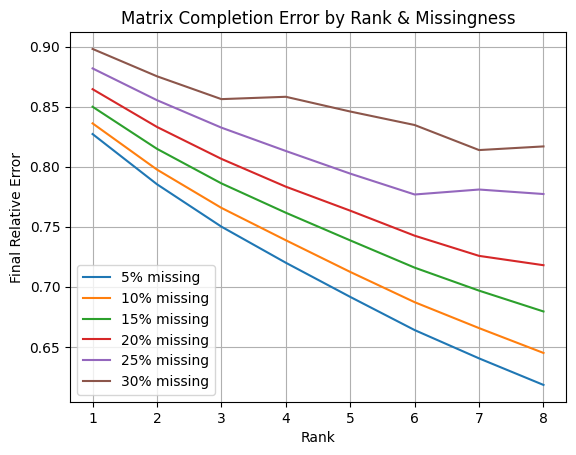

In [11]:
import matplotlib.pyplot as plt

for frac in missing_levels:
    plt.plot(ranks, results[frac], label=f"{int(frac*100)}% missing")

plt.xlabel("Rank")
plt.ylabel("Final Relative Error")
plt.title("Matrix Completion Error by Rank & Missingness")
plt.legend()
plt.grid(True)
plt.show()

- The plot above that is generated shows how error changes as we increase the SVD rank and simulate more missing data.
- X-axis shows the SVD rank from 1 to 8, where a higher rank means more components are used in reconstruction.
- Y-axis shows Final relative error where lower means better reconstruction and more accurate completion.
- The plot has different colors used for different missing values.
- Increasing the rank consistently boosts performance.
- As anticipated with low-rank SVD, all lines show a downward trend.
- Rank 8 consistently shows the lowest relative error.
- When there’s more missing data, the error increases.
- Across all ranks, greater missingness (indicated by darker lines) leads to poorer reconstruction.
- For instance, a 5% missing rate performs significantly better than a 30% missing rate.
- After a certain point, improvements begin to taper off.
- At higher ranks, such as 7 and 8, the rate of improvement starts to slow, especially with increased missing data.

In [14]:
trials = 5  # Repeat the experiment 5 times

avg_results = {}

# Loop over missing percentages
for frac in missing_levels:
    avg_errors = []

    for r in ranks:
        errors = []

        for t in range(trials):
            # Create a new masked matrix each trial
            X_missing, _ = mask_matrix(X_scaled, missing_fraction=frac, seed=t)

            # Apply matrix completion
            _, error = svd_matrix_completion(X_missing, rank=r)
            errors.append(error[-1])  # Take final error only

        # Average across trials
        avg_errors.append(np.mean(errors))

    avg_results[frac] = avg_errors

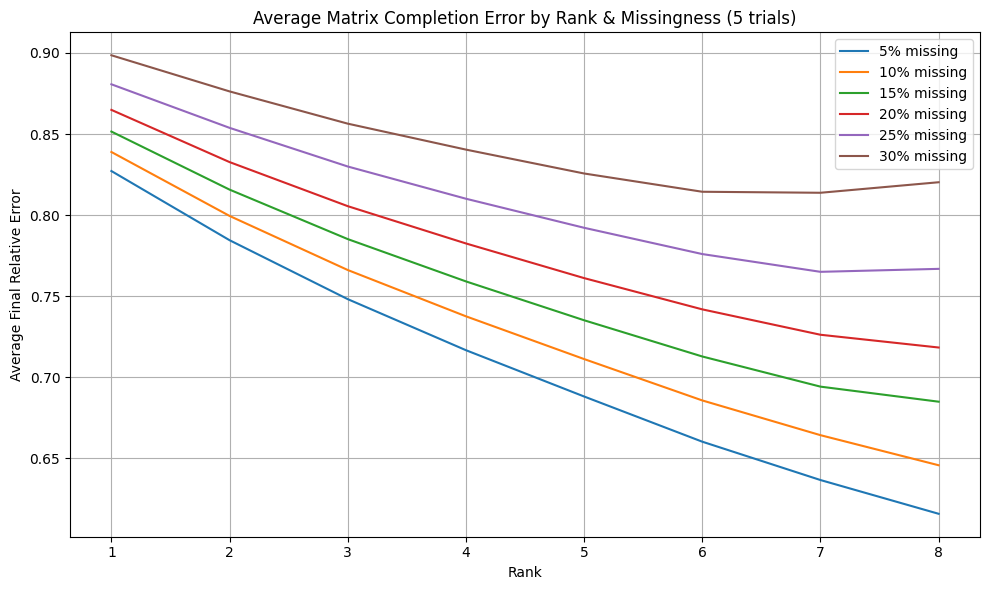

In [15]:
# Plot the averaged matrix completion error vs. rank
plt.figure(figsize=(10, 6))

for frac in missing_levels:
    plt.plot(ranks, avg_results[frac], label=f"{int(frac*100)}% missing")

plt.xlabel("Rank")
plt.ylabel("Average Final Relative Error")
plt.title("Average Matrix Completion Error by Rank & Missingness (5 trials)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()